In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, cross_validate, KFold, train_test_split
from sklearn.metrics import make_scorer, f1_score, r2_score, confusion_matrix, roc_curve, auc, recall_score, precision_score, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import ast
import re
import tqdm

pd.options.display.max_rows = 50

In [12]:
data = pd.read_csv('data_lec.csv')

data

,Unnamed: 0,timestamp,ppm1,temp1,temp2,ppm2,gas_opening1,press1,rotationspeed1,press3,...,SIM2,LSF2,electric_ampere2,electric_ampere3,temp5,target,target_ffill,electric_ampere_delta1,coeffs_current1,coeffs_temp1
0,0,2023-09-04 05:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006982,NaN,NaN
1,1,2023-09-04 05:02:00+00:00,NaN,767.616089,301.616760,NaN,4.334852,0.338180,0.0,0.00,...,NaN,NaN,27.00,NaN,781.098145,NaN,NaN,0.018020,NaN,NaN
2,2,2023-09-04 05:03:00+00:00,NaN,767.758545,302.511932,NaN,4.304109,0.388817,0.0,0.00,...,NaN,NaN,27.00,NaN,781.050659,NaN,NaN,0.015809,NaN,NaN
3,3,2023-09-04 05:04:00+00:00,NaN,767.806030,303.645836,NaN,4.303205,0.353552,0.0,0.00,...,NaN,NaN,27.00,NaN,781.050659,NaN,NaN,0.013946,NaN,NaN
4,4,2023-09-04 05:05:00+00:00,NaN,767.806000,304.222733,NaN,4.290545,0.349031,0.0,0.00,...,NaN,NaN,27.00,NaN,780.870209,NaN,NaN,0.023489,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81250,81250,2023-10-30 04:56:00+00:00,1997.375000,738.297516,853.247971,7.269966,66.784216,59.582068,0.0,84.25,...,NaN,NaN,49.00,NaN,839.668793,NaN,0.2959,11.349274,-0.091511,1.583574
81251,81251,2023-10-30 04:57:00+00:00,2004.992798,740.794556,854.441544,6.949870,66.855650,59.689670,0.0,77.75,...,NaN,NaN,48.00,NaN,839.839706,NaN,0.2959,13.185791,-0.150697,1.363653
81252,81252,2023-10-30 04:58:00+00:00,1991.647949,741.696472,858.728470,6.807002,67.096172,59.790038,0.0,60.75,...,NaN,NaN,49.00,NaN,837.798401,NaN,0.2959,9.115753,-0.184328,1.216280
81253,81253,2023-10-30 04:59:00+00:00,1901.381104,741.952820,859.554001,7.396557,68.359375,60.184281,0.0,37.50,...,NaN,NaN,49.00,NaN,838.966217,NaN,0.2959,14.056274,NaN,1.121430


<AxesSubplot:xlabel='timestamp', ylabel='target'>

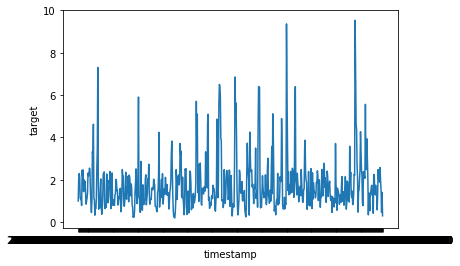

In [6]:
data_target = data[data['target'].notna()]
sns.lineplot(data=data_target,x="timestamp",y="target")

<AxesSubplot:>

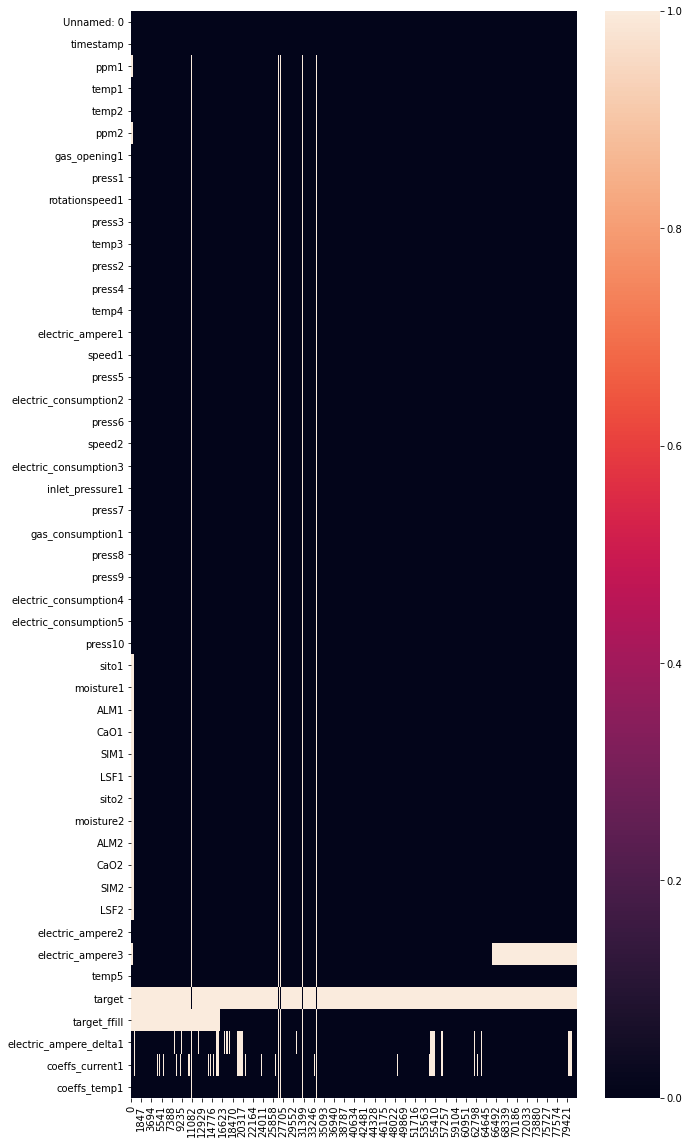

In [7]:
plt.figure(figsize=(10,20))
sns.heatmap(data.isna().transpose())

In [8]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df.tail(10)

,column_name,percent_missing
moisture2,moisture2,1.631900
ALM2,ALM2,1.631900
CaO2,CaO2,1.631900
LSF2,LSF2,1.631900
SIM2,SIM2,1.631900
electric_ampere_delta1,electric_ampere_delta1,8.269030
coeffs_current1,coeffs_current1,8.842533
electric_ampere3,electric_ampere3,20.226448
target_ffill,target_ffill,20.526737
target,target,99.234509


In [26]:
df = data.drop(columns=['target_ffill','electric_ampere3']) # Дропаем сильно пустые колонки

# Считаем, что данные у нас появляются раз в минуту, тогда сделаем shift(15) для прогноза на 15 минут вперёд

for column in df.columns:
    if column not in ['timestamp']:
        df[f'{column}_shift_15'] = df[column].shift(15)
df = df[['timestamp','target'] + [col for col in df.columns if '_shift_15' in col]]

# Сгенерируем ещё фичей для перебора, обычно можно добавить ещё агрегации last, max, min

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    if column not in ['target']:
        df[f'rolling_mean_15_{column}'] = df[column].rolling(window=15, min_periods=1).mean()
        df[f'rolling_mean_5_{column}'] = df[column].rolling(window=5, min_periods=1).mean()
        
df = df.dropna(subset=['target'])
df = df.drop(['target_shift_15'], axis=1)
df = df.ffill()
df = df.dropna()

In [27]:
df

,timestamp,target,Unnamed: 0_shift_15,ppm1_shift_15,temp1_shift_15,temp2_shift_15,ppm2_shift_15,gas_opening1_shift_15,press1_shift_15,rotationspeed1_shift_15,...,rolling_mean_15_temp5_shift_15,rolling_mean_5_temp5_shift_15,rolling_mean_15_target_shift_15,rolling_mean_5_target_shift_15,rolling_mean_15_electric_ampere_delta1_shift_15,rolling_mean_5_electric_ampere_delta1_shift_15,rolling_mean_15_coeffs_current1_shift_15,rolling_mean_5_coeffs_current1_shift_15,rolling_mean_15_coeffs_temp1_shift_15,rolling_mean_5_coeffs_temp1_shift_15
11487,2023-09-12 03:16:30+00:00,1.04847,11472.0,1354.821899,790.554443,919.163223,16.977720,78.804073,72.220413,54.992676,...,839.535863,836.910683,0.78905,0.78905,13.136684,15.947433,-0.168318,0.040709,-0.472331,-0.647892
11597,2023-09-12 05:05:42+00:00,0.81018,11582.0,1196.202759,797.960083,910.231293,13.420501,77.471245,71.618200,54.992676,...,832.115075,826.832416,0.78905,0.78905,16.212649,14.950000,1.888615,1.870816,-0.642116,0.180789
11695,2023-09-12 06:42:53+00:00,0.78801,11680.0,1954.840454,810.122375,962.131973,8.147063,78.599718,72.421152,0.000000,...,839.924814,839.881473,0.78905,0.78905,17.097786,21.277643,0.414392,0.053813,1.161468,3.018048
11734,2023-09-12 07:20:27+00:00,1.30127,11719.0,1737.561279,807.900665,923.539658,8.436415,76.550747,70.911095,54.992676,...,838.593406,837.940814,0.78905,0.78905,7.468443,10.383911,-1.610335,-1.271538,-0.932993,-3.073409
11752,2023-09-12 07:37:44+00:00,1.32613,11737.0,1683.122925,808.517822,928.602478,6.669560,76.208046,71.025032,54.992676,...,839.457529,839.647430,1.30127,1.30127,14.033925,5.990702,-0.140713,0.112094,-2.925148,-0.128853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80593,2023-10-29 18:03:07+00:00,1.89618,80578.0,1253.950195,758.976227,777.893539,5.949798,63.979311,58.465347,0.000000,...,830.973858,837.247729,4.35933,4.12639,6.389221,8.473840,0.216205,0.272609,-1.320850,-0.636839
80662,2023-10-29 19:11:54+00:00,1.48818,80647.0,1339.656128,770.084625,806.380188,6.931785,63.296621,55.324074,0.000000,...,829.786848,828.712308,4.35933,4.12639,6.587720,4.232703,-0.026677,-0.359918,-0.365608,-0.665264
80761,2023-10-29 20:49:54+00:00,0.45586,80746.0,1748.884521,736.512604,833.146194,7.123481,70.698603,61.223234,0.000000,...,831.094739,829.614249,4.35933,4.12639,3.689811,3.979175,-0.366462,-0.133641,0.313558,-0.089890
80907,2023-10-29 23:14:55+00:00,1.40011,80892.0,1681.820923,757.181824,800.869858,6.570095,65.725368,59.818069,0.000000,...,833.774678,835.299475,4.35933,4.12639,4.455613,4.947626,0.464420,0.678412,-1.770989,-1.223964


In [ ]:
# Пройдёмся по фичам и выберем лучшие, код выполнял, на более мощном железе, чтобы не тратить час на catboost

rs = 42

model_params_grid = { # Модели по которым посмотрим метрики
    "LinearRegression": (LinearRegression(
                                            n_jobs=-1
                                            )),
    "RandomForestRegressor": (RandomForestRegressor(
        random_state=rs,
         n_jobs=-1
    ))
    ,"CatBoostRegressor": (CatBoostRegressor(random_state=rs,
                                            thread_count=-1, verbose=False
                                            ))
}
research_name = 'time_series_rfe'
dict_ = {}
for model_name, (model) in model_params_grid.items():
    dict_[model_name] = {}
    dict_[model_name]['count'] = []
    dict_[model_name]['features'] = []
    dict_[model_name]['RMSE'] = []
    dict_[model_name]['R2'] = []

    scoring = ['r2', 'neg_root_mean_squared_error'] # Сами метрики

    for i in tqdm(range(1, 41)): # Не буду смотреть варианты по 40+ фичей, для жкономии времени, да и просто это много
        dict_[model_name]['count'].append(i)

        model_for_rfe = model
        selector = RFE(model_for_rfe, n_features_to_select=i, step=1)
        selector.fit(X, y)

        cols = X.columns[selector.support_].to_list()
        dict_[model_name]['features'].append(cols)

        score = cross_validate(model, X[cols], y, cv=TimeSeriesSplit(n_splits=10),
                                 # TimeSeriesSplit чтобы не подсматривать в будущее
                               scoring=scoring, n_jobs=-1, error_score='raise')
        dict_[model_name]['RMSE'].append(-score.get('test_neg_root_mean_squared_error')[-1])
        dict_[model_name]['R2'].append(score.get('test_r2')[-1])
        # Берём последние значений [-1] чтобы получить только значения с последнего теста, где test_size = 0.1

# Запись в excel, чтобы можно было глазами посмотреть, но в жтом примере загружу обратно в блокнот
with pd.ExcelWriter('results_' + research_name + '.xlsx', engine='xlsxwriter') as writer:
    for sheet_name, records in dict_.items():
        df = pd.DataFrame(records)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [63]:
selection_results = pd.read_excel('results_time_series_rfe.xlsx',sheet_name = None)

In [37]:
dfs = []
for sheet_name, result in selection_results.items():
    result['model'] = sheet_name
    dfs.append(result)
    
result_df = pd.concat(dfs, ignore_index=True)

In [39]:
result_df

,count,features,RMSE,R2,model
0,1,['rolling_mean_5_ALM2_shift_15'],0.976554,0.045130,LinearRegression
1,2,"['rolling_mean_5_ALM2_shift_15', 'rolling_mean...",0.947126,0.101812,LinearRegression
2,3,"['ALM2_shift_15', 'rolling_mean_5_ALM2_shift_1...",0.947107,0.101848,LinearRegression
3,4,"['ALM2_shift_15', 'rolling_mean_5_ALM2_shift_1...",0.931987,0.130297,LinearRegression
4,5,"['ALM2_shift_15', 'SIM2_shift_15', 'rolling_me...",0.931988,0.130294,LinearRegression
...,...,...,...,...,...
115,36,"['temp2_shift_15', 'press2_shift_15', 'speed1_...",1.053506,-0.111286,CatBoostRegressor
116,37,"['temp2_shift_15', 'ppm2_shift_15', 'press2_sh...",1.039222,-0.081355,CatBoostRegressor
117,38,"['temp2_shift_15', 'ppm2_shift_15', 'press3_sh...",0.995615,0.007491,CatBoostRegressor
118,39,"['temp2_shift_15', 'ppm2_shift_15', 'press3_sh...",0.991492,0.015693,CatBoostRegressor


In [42]:
sorted_results = result_df.sort_values(by=['R2'], ascending=False)
sorted_results

,count,features,RMSE,R2,model
6,7,"['ALM2_shift_15', 'CaO2_shift_15', 'SIM2_shift...",0.897990,0.192589,LinearRegression
9,10,"['ALM2_shift_15', 'CaO2_shift_15', 'SIM2_shift...",0.907802,0.174848,LinearRegression
8,9,"['ALM2_shift_15', 'CaO2_shift_15', 'SIM2_shift...",0.908836,0.172966,LinearRegression
7,8,"['ALM2_shift_15', 'CaO2_shift_15', 'SIM2_shift...",0.909407,0.171927,LinearRegression
10,11,"['ALM2_shift_15', 'CaO2_shift_15', 'SIM2_shift...",0.921213,0.150287,LinearRegression
...,...,...,...,...,...
37,38,"['gas_opening1_shift_15', 'temp3_shift_15', 's...",1.251975,-0.569434,LinearRegression
44,5,"['press2_shift_15', 'gas_consumption1_shift_15...",1.294031,-0.676646,RandomForestRegressor
45,6,"['press2_shift_15', 'gas_consumption1_shift_15...",1.310035,-0.718374,RandomForestRegressor
39,40,"['gas_opening1_shift_15', 'press1_shift_15', '...",1.313690,-0.727975,LinearRegression


In [54]:
features = ast.literal_eval(sorted_results.iloc[0, 1])
print(features)
rmse = sorted_results.iloc[0, 2]
print(rmse)
r2 = sorted_results.iloc[0, 3]
print(r2)

['ALM2_shift_15', 'CaO2_shift_15', 'SIM2_shift_15', 'rolling_mean_15_ALM2_shift_15', 'rolling_mean_5_ALM2_shift_15', 'rolling_mean_15_SIM2_shift_15', 'rolling_mean_5_SIM2_shift_15']
0.8979900358544154
0.1925887108201552


### Прогноз на 15 минут вперёд

In [57]:
future_data = df.tail(1)

# так как у нас сделан shift(15), и данные приходят с интервалом в минуту
# то входной вектор для прогноза с максимальным timestamp и даст нам получить прогноз на 15 минут вперёд

model.fit(df[features], df['target']) # не делим данные на train и test для максимизации обучающей выборки
predict_15_min = model.predict(future_data[features])

print(predict_15_min)

[0.59712077]


### Отклонение прогнозов от стандартных значений

In [59]:
def monitor_target(predictions):
    for pred in predictions:
        if pred < 1:
            print("Warning: Target below 1")
        elif pred > 2:
            print("Warning: Target above 2")
        else:
            print("OK") # По хорошему такой вывод нам не нужем, чтобы не спамить работникам производства, но для теста добавлю

In [60]:
monitor_target(predict_15_min)

### Прогноз с изменением показателя

In [ ]:
# В список фичей моей модели показатель 'gas_consumption1' не попал,
# но это не мешает реализовать функцию, способную изменять значения необходимой переменной в случае прогноза

def predict_with_change(data, feature, change, model):
    data_copy = data.copy()
    data_copy[feature] += change
    return model.predict(data_copy[important_features])

# Пример запуска
change_predictions = predict_with_change(data.tail(1), 'gas_consumption1', 150, model)